In [1]:
# !pip install tensorflow keras gym prometheus-api-client boto3 numpy pandas matplotlib tensorflow==2.10 keras==2.10 --force-reinstall --upgrade keras-rl2


In [2]:
import os
os.environ["PROM_URL"] = "http://localhost:9090"
os.environ["TARGET_DEPLOYMENT"] = "nginx"
os.environ["TARGET_NAMESPACE"] = "default"


In [3]:
import gym
from gym import spaces
import numpy as np
import time
import datetime as dt
import os

from prometheus_api_client import PrometheusConnect
from kubernetes import client, config

PROM_URL = os.getenv("PROM_URL", "http://localhost:9090")
DEPLOYMENT = os.getenv("TARGET_DEPLOYMENT", "nginx")
NAMESPACE = os.getenv("TARGET_NAMESPACE", "default")
SLA_MS = 200
MAX_REPLICAS = 5
MIN_REPLICAS = 1
BETA = 5.0  # latency penalty weight

class KubeScalingEnv(gym.Env):
    """Prometheus + K8s integrated Gym environment for RL autoscaling."""

    def __init__(self):
        super(KubeScalingEnv, self).__init__()

        self.action_space = spaces.Discrete(MAX_REPLICAS)  # actions = 0 to 4 → replicas 1 to 5
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(5,), dtype=np.float32)
        self.step_count = 0
        self.max_steps = 10

        # Prometheus and K8s clients
        self.prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)
        try:
            config.load_incluster_config()
        except:
            config.load_kube_config()
        self.apps = client.AppsV1Api()
        

        self.current_replicas = 3
        self.state = self._get_state()


    def _query(self, query):
        try:
            result = self.prom.custom_query(query)
            if not result:
                return 0.0
            return float(result[0]["value"][1])
        except:
            return 0.0

    def _get_state(self):
    # Query raw values (these might still be static depending on workload)
        cpu = self._query(f"avg(rate(container_cpu_usage_seconds_total{{namespace='{NAMESPACE}', pod=~'{DEPLOYMENT}.*'}}[60s]))")
        mem = self._query(f"avg(container_memory_working_set_bytes{{namespace='{NAMESPACE}', pod=~'{DEPLOYMENT}.*'}})/1e9")
        lat = self._query(f"histogram_quantile(0.95, sum(rate(http_request_duration_seconds_bucket{{namespace='{NAMESPACE}'}}[60s])) by (le))")

    # Add synthetic variation to simulate workload changes
        cpu += np.random.uniform(0.01, 0.2)
        mem += np.random.uniform(0.01, 0.1)
        lat += np.random.uniform(-0.05, 0.05)

    # Clip to avoid negatives
        cpu = max(cpu, 0.0)
        mem = max(mem, 0.0)
        lat = max(lat, 0.0)

        latency_ms = lat * 1000
        spot_price = 0.02  # Assume constant unless pulled dynamically

        state = np.array([
            min(cpu / 1.0, 1.0),
            min(mem / 1.0, 1.0),
            min(latency_ms / 1000.0, 1.0),
            (self.current_replicas - MIN_REPLICAS) / (MAX_REPLICAS - MIN_REPLICAS),
            min(spot_price / 0.12, 1.0)
        ], dtype=np.float32)

        state = np.reshape(state, (5,)) 

        print(f"DEBUG raw 5-tuple → cpu={cpu:.3f}, mem={mem:.3f}, lat={latency_ms:.1f}ms, replicas={self.current_replicas}, price={spot_price}")
        if state.shape != (5,):
            print("❌ INVALID STATE SHAPE →", state)
            state = np.zeros((5,), dtype=np.float32)  # fallback

        return state



    def _scale(self, replicas):
        replicas = int(replicas)
        body = {"spec": {"replicas": replicas}}
        self.apps.patch_namespaced_deployment_scale(name=DEPLOYMENT, namespace=NAMESPACE, body=body)

    def step(self, action):
        self.step_count += 1
        print(f"Step count: {self.step_count}")
        done = self.step_count >= self.max_steps
        self.current_replicas = MIN_REPLICAS + action
        self._scale(self.current_replicas)
        time.sleep(3)  # wait for scaling to settle

        state = self._get_state()
        spot_price = 0.02
        cost = self.current_replicas * spot_price / 3600 * 15

        latency_ms = state[2] * 1000
        latency_penalty = max(0, latency_ms - SLA_MS) / 1000
        reward = - (cost + BETA * latency_penalty)
        
        print(f"[KubeScalingEnv] action={action} → replicas={self.current_replicas}, "
          f"latency={latency_ms:.2f}ms, reward={reward:.4f}, cost={cost:.5f}")

        truncated = False
        info = {
            "replicas": self.current_replicas,
            "latency": latency_ms,
            "cost": cost,
            "reward": reward
        }

        self.state = state  # ✅ This ensures state is updated

        return self.state, reward, done, truncated, info


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0
        self.current_replicas = 3
        self._scale(self.current_replicas)
        self.state = self._get_state()
        return self.state, {}

    def render(self):
        print(f"Current replicas: {self.current_replicas}")


In [4]:
# from stable_baselines3 import PPO
# env = KubeScalingEnv()
# model = PPO("MlpPolicy", env, verbose=1,n_steps=10)
# model.learn(total_timesteps=10)
# model.save("ppo_kube")


2025-07-28 14:27:17.887885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-28 14:27:18.328312: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 14:27:18.417188: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-28 14:27:19.378747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

DEBUG raw 5-tuple → cpu=0.039, mem=0.043, lat=1.8ms, replicas=3, price=0.02
>>> FINAL state shape (inside env): (5,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 24)                144       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 5)                 125       
                                                                 
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________
None


2025-07-28 14:27:21.723982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-28 14:27:21.808234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/magesh/.local/lib/python3.10/site-packages/cv2/../../lib64:
2025-07-28 14:27:21.808300: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-07-28 14:27:21.810165: I tensorflow/core/platform/cpu_feature_guard.cc

Env observation space shape from env object: (5,)
Training for 1000 steps ...
DEBUG raw 5-tuple → cpu=0.048, mem=0.030, lat=47.5ms, replicas=3, price=0.02
>>> FINAL state shape (inside env): (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 1


/home/magesh/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


DEBUG raw 5-tuple → cpu=0.199, mem=0.040, lat=41.9ms, replicas=5, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=4 → replicas=5, latency=41.93ms, reward=-0.0004, cost=0.00042
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 2
DEBUG raw 5-tuple → cpu=0.134, mem=0.059, lat=83.7ms, replicas=2, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=1 → replicas=2, latency=83.74ms, reward=-0.0002, cost=0.00017
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 3
DEBUG raw 5-tuple → cpu=0.084, mem=0.101, lat=87.8ms, replicas=1, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] acti

/home/magesh/.local/lib/python3.10/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 4
DEBUG raw 5-tuple → cpu=0.094, mem=0.066, lat=58.0ms, replicas=3, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=2 → replicas=3, latency=58.03ms, reward=-0.0003, cost=0.00025
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 5
DEBUG raw 5-tuple → cpu=0.083, mem=0.029, lat=16.4ms, replicas=4, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=3 → replicas=4, latency=16.37ms, reward=-0.0003, cost=0.00033
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (proce

/home/magesh/.local/lib/python3.10/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


DEBUG raw 5-tuple → cpu=0.125, mem=0.100, lat=26.4ms, replicas=4, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=3 → replicas=4, latency=26.38ms, reward=-0.0003, cost=0.00033
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 3
DEBUG raw 5-tuple → cpu=0.027, mem=0.093, lat=77.2ms, replicas=5, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=4 → replicas=5, latency=77.22ms, reward=-0.0004, cost=0.00042
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batc

/home/magesh/.local/lib/python3.10/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


DEBUG raw 5-tuple → cpu=0.148, mem=0.027, lat=40.2ms, replicas=5, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=4 → replicas=5, latency=40.18ms, reward=-0.0004, cost=0.00042
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 3
DEBUG raw 5-tuple → cpu=0.088, mem=0.089, lat=49.3ms, replicas=1, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=0 → replicas=1, latency=49.31ms, reward=-0.0001, cost=0.00008
>>> STEP return shape: (5,)
Processor (process_observation): incoming observation shape: (5,)
Processor (process_state_batch): State batch shape before model: (32, 1, 5)
Processor (process_state_batc

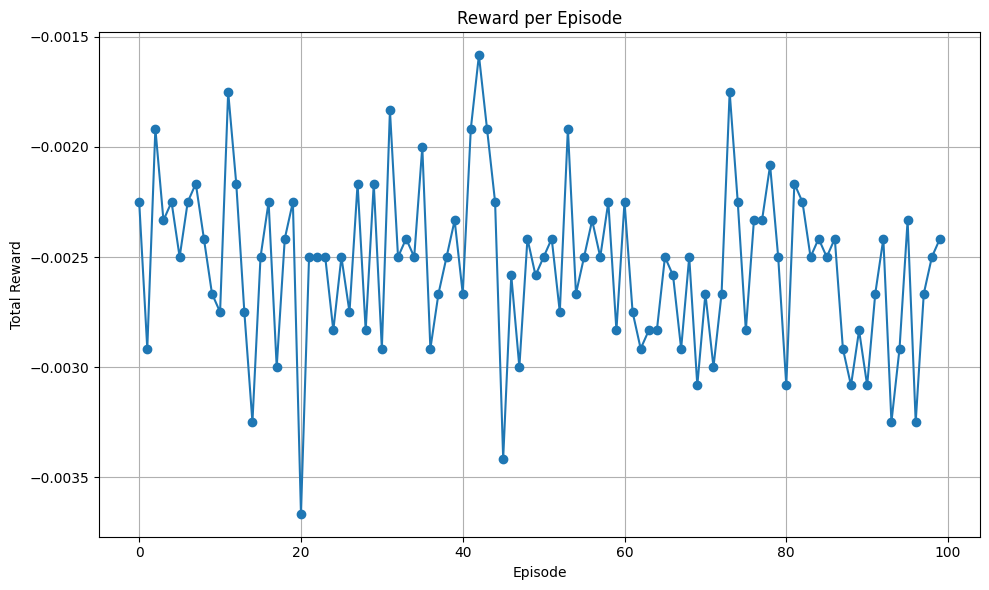

In [5]:
import numpy as np
import tensorflow as tf
import gym
from gym import spaces
from gym import Wrapper
import time
import datetime as dt
import os
from prometheus_api_client import PrometheusConnect
from kubernetes import client, config
from rl.callbacks import Callback
import matplotlib.pyplot as plt


# Disable eager execution for compatibility with keras-rl
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.processors import Processor

# Constants for KubeScalingEnv
PROM_URL = os.getenv("PROM_URL", "http://localhost:9090")
DEPLOYMENT = os.getenv("TARGET_DEPLOYMENT", "nginx")
NAMESPACE = os.getenv("TARGET_NAMESPACE", "default")
SLA_MS = 200
MAX_REPLICAS = 5
MIN_REPLICAS = 1
BETA = 5.0  # latency penalty weight

# Flag to enable/disable Q-value computation
COMPUTE_Q_VALUES = True  # Set to False to skip Q-value computation

class RewardLogger(Callback):
    def __init__(self):
        self.episode_rewards = []
        self.episode_reward = 0

    def on_episode_begin(self, episode, logs={}):
        self.episode_reward = 0

    def on_step_end(self, step, logs={}):
        self.episode_reward += logs.get('reward', 0)

    def on_episode_end(self, episode, logs={}):
        self.episode_rewards.append(self.episode_reward)
        print(f"[Episode {episode}] Total Reward: {self.episode_reward:.4f}")
        
# LegacyGymWrapper to adapt 5-tuple to 4-tuple
class LegacyGymWrapper(Wrapper):
    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        return observation, reward, done, info

# DebugProcessor
class DebugProcessor(Processor):
    def process_observation(self, observation):
        if isinstance(observation, tuple) and len(observation) == 2:
            actual_observation = observation[0]
        else:
            actual_observation = observation
        print(f"Processor (process_observation): incoming observation shape: {actual_observation.shape}")
        if actual_observation.shape != (5,):
            print(f"Processor (process_observation): WARNING! Observation shape mismatch: {actual_observation.shape}")
            return np.zeros((5,), dtype=np.float32)
        return actual_observation

    def process_state_batch(self, batch):
        print(f"Processor (process_state_batch): State batch shape before model: {batch.shape}")
        # Ensure batch retains expected shape (batch_size, window_length, 5)
        if len(batch.shape) > 3:
            batch = batch.squeeze(axis=1)  # Remove extra dimension if present
        return batch

# KubeScalingEnv
class KubeScalingEnv(gym.Env):
    def __init__(self):
        super(KubeScalingEnv, self).__init__()
        self.action_space = spaces.Discrete(MAX_REPLICAS)  # actions = 0 to 4 → replicas 1 to 5
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(5,), dtype=np.float32)
        self.step_count = 0
        self.max_steps = 10
        self.prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)
        try:
            config.load_incluster_config()
        except:
            config.load_kube_config()
        self.apps = client.AppsV1Api()
        self.current_replicas = 3
        self.state = self._get_state()

    def _query(self, query):
        try:
            result = self.prom.custom_query(query)
            if not result:
                print(f"WARNING: Prometheus query returned empty result for: {query}")
                return 0.0
            return float(result[0]["value"][1])
        except Exception as e:
            print(f"ERROR: Prometheus query failed for {query}: {e}")
            return 0.0

    def _get_state(self):
        cpu = self._query(f"avg(rate(container_cpu_usage_seconds_total{{namespace='{NAMESPACE}', pod=~'{DEPLOYMENT}.*'}}[60s]))")
        mem = self._query(f"avg(container_memory_working_set_bytes{{namespace='{NAMESPACE}', pod=~'{DEPLOYMENT}.*'}})/1e9")
        lat = self._query(f"histogram_quantile(0.95, sum(rate(http_request_duration_seconds_bucket{{namespace='{NAMESPACE}'}}[60s])) by (le))")
        # Fallback for latency if query fails
        if lat == 0.0:
            lat = 0.05  # Assume 50ms latency to avoid zeroed state
        cpu += np.random.uniform(0.01, 0.2)
        mem += np.random.uniform(0.01, 0.1)
        lat += np.random.uniform(-0.05, 0.05)
        cpu = max(cpu, 0.0)
        mem = max(mem, 0.0)
        lat = max(lat, 0.0)
        latency_ms = lat * 1000
        spot_price = 0.02
        state = np.array([
            min(cpu / 1.0, 1.0),
            min(mem / 1.0, 1.0),
            min(latency_ms / 1000.0, 1.0),
            (self.current_replicas - MIN_REPLICAS) / (MAX_REPLICAS - MIN_REPLICAS),
            min(spot_price / 0.12, 1.0)
        ], dtype=np.float32)
        state = np.reshape(state, (5,))
        print(f"DEBUG raw 5-tuple → cpu={cpu:.3f}, mem={mem:.3f}, lat={latency_ms:.1f}ms, replicas={self.current_replicas}, price={spot_price}")
        print(">>> FINAL state shape (inside env):", state.shape)
        if state.shape != (5,):
            print("❌ INVALID STATE SHAPE →", state)
            state = np.zeros((5,), dtype=np.float32)
        return state

    def _scale(self, replicas):
        try:
            replicas = int(replicas)
            body = {"spec": {"replicas": replicas}}
            self.apps.patch_namespaced_deployment_scale(name=DEPLOYMENT, namespace=NAMESPACE, body=body)
        except Exception as e:
            print(f"ERROR: Failed to scale deployment {DEPLOYMENT} in namespace {NAMESPACE}: {e}")

    def step(self, action):
        self.step_count += 1
        print(f"Step count: {self.step_count}")
        done = self.step_count >= self.max_steps
        self.current_replicas = MIN_REPLICAS + action
        self._scale(self.current_replicas)
        time.sleep(3)
        state = self._get_state()
        print(">>> FINAL state shape4:", state.shape)
        spot_price = 0.02
        cost = self.current_replicas * spot_price / 3600 * 15
        latency_ms = state[2] * 1000
        latency_penalty = max(0, latency_ms - SLA_MS) / 1000
        reward = - (cost + BETA * latency_penalty)
        print(f"[KubeScalingEnv] action={action} → replicas={self.current_replicas}, "
              f"latency={latency_ms:.2f}ms, reward={reward:.4f}, cost={cost:.5f}")
        truncated = False
        info = {
            "replicas": self.current_replicas,
            "latency": latency_ms,
            "cost": cost,
            "reward": reward
        }
        self.state = state
        print(">>> STEP return shape:", self.state.shape)
        return self.state, reward, done, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0
        self.current_replicas = 3
        self._scale(self.current_replicas)
        self.state = self._get_state()
        return self.state  # Return state only for keras-rl compatibility

    def render(self):
        print(f"Current replicas: {self.current_replicas}")

    def get_current_state(self):
        return self.state

# Initialize and wrap the environment
env = KubeScalingEnv()
env = LegacyGymWrapper(env)  # Apply the wrapper

# Get environment properties
nb_actions = env.action_space.n
obs_shape = env.observation_space.shape  # (5,)
window_length = 1

# Build the DQN model
model = Sequential()
model.add(Flatten(input_shape=(window_length,) + obs_shape))  # Expects (1, 5)
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

print(model.summary())

# Configure the DQN agent
memory = SequentialMemory(limit=50000, window_length=window_length)
policy = BoltzmannQPolicy()
dqn = DQNAgent(
    model=model,
    nb_actions=nb_actions,
    memory=memory,
    nb_steps_warmup=1,  # Reduced for 10-step test
    target_model_update=1e-2,
    policy=policy,
    enable_double_dqn=True,
    processor=DebugProcessor()
)

# Compile and train
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
print(f"Env observation space shape from env object: {env.observation_space.shape}")
reward_logger = RewardLogger()
dqn.fit(env, nb_steps=1000, visualize=False, verbose=2, callbacks=[reward_logger])


# Save weights
dqn.save_weights('dqn_kube_weights.h5', overwrite=True)

# Post-training Q-value computation (optional)
if COMPUTE_Q_VALUES:
    state = env.env.get_current_state()  # Use env.env to access unwrapped KubeScalingEnv
    print(">>> Final state shape:", state.shape)
    state_input = state[np.newaxis, np.newaxis, :]  # Shape: (1, 1, 5)
    print(">>> State input shape for DQN (manual prediction):", state_input.shape)
    q_values = dqn.compute_q_values(state_input)
    print("Q-values for current state:")
    for i, q in enumerate(q_values):
        print(f"Action {i} → replicas {i+1}: Q-value = {q:.5f}")


# Plot total reward per episode
plt.figure(figsize=(10, 6))
plt.plot(reward_logger.episode_rewards, marker='o')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.savefig("reward_plot.png")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Apply a simple moving average to smooth the rewards
def smooth_rewards(rewards, window_size=5):
    return np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

# Assuming reward_logger.episode_rewards is the list of rewards per episode
smoothed_rewards = smooth_rewards(reward_logger.episode_rewards, window_size=5)

# Plot the smoothed rewards
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, marker='o', label='Smoothed Reward', color='b')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Smoothed Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig("smoothed_reward_plot.png")
plt.show()


In [7]:
state = env.get_current_state()
state_input = np.expand_dims(np.expand_dims(state, axis=0), axis=0)
q_values = dqn.compute_q_values(state_input)

print("Q-values for current state:")
for i, q in enumerate(q_values):
    print(f"Action {i} → replicas {i+1}: Q-value = {q:.5f}")


Processor (process_state_batch): State batch shape before model: (1, 1, 1, 5)
Q-values for current state:
Action 0 → replicas 1: Q-value = 0.03454
Action 1 → replicas 2: Q-value = 0.03346
Action 2 → replicas 3: Q-value = 0.03294
Action 3 → replicas 4: Q-value = 0.02628
Action 4 → replicas 5: Q-value = 0.01899


DEBUG raw 5-tuple → cpu=0.061, mem=0.046, lat=81.9ms, replicas=3, price=0.02
>>> FINAL state shape (inside env): (5,)
DEBUG raw 5-tuple → cpu=0.162, mem=0.020, lat=70.2ms, replicas=3, price=0.02
>>> FINAL state shape (inside env): (5,)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 1
DEBUG raw 5-tuple → cpu=0.187, mem=0.038, lat=88.0ms, replicas=2, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=1 → replicas=2, latency=88.00ms, reward=-0.0002, cost=0.00017
>>> STEP return shape: (5,)
Processor (process_state_batch): State batch shape before model: (1, 1, 5)
Step count: 2
DEBUG raw 5-tuple → cpu=0.084, mem=0.021, lat=58.0ms, replicas=5, price=0.02
>>> FINAL state shape (inside env): (5,)
>>> FINAL state shape4: (5,)
[KubeScalingEnv] action=4 → replicas=5, latency=58.03ms, reward=-0.0004, cost=0.00042
>>> STEP return shape: (5,)
Processor (process_state_batch): State batch shape before model:

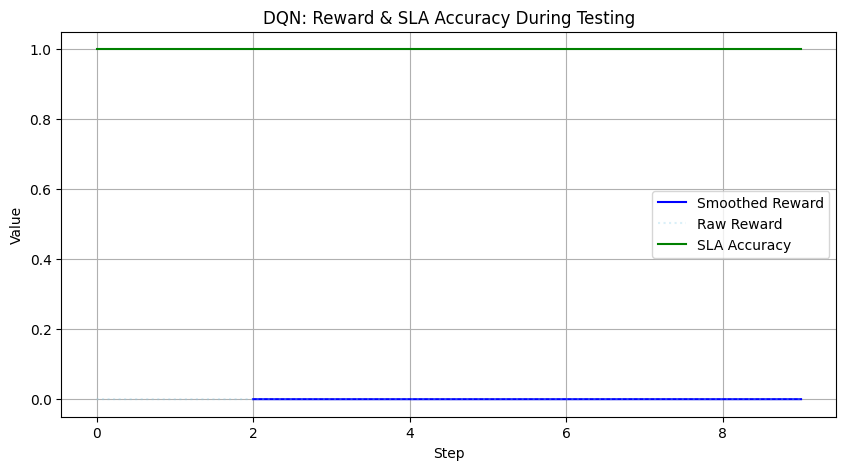

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload environment
env_test = KubeScalingEnv()
env_test = LegacyGymWrapper(env_test)

# Reload DQN weights
dqn.load_weights("dqn_kube_weights.h5")

# Initialize state and metrics
obs = env_test.reset()
rewards = []
accuracies = []
sla_violations = 0
SLA_THRESHOLD = 200

# Test loop
for step in range(100):
    action = dqn.forward(obs)  # use forward() for inference
    obs, reward, done, info = env_test.step(action)
    
    rewards.append(reward)

    if info["latency"] > SLA_THRESHOLD:
        sla_violations += 1
    accuracy = 1 - (sla_violations / (step + 1))
    accuracies.append(accuracy)

    if done:
        break

# Save metrics to CSV
df = pd.DataFrame({
    "reward": rewards,
    "accuracy": accuracies
})
df.to_csv("dqn_reward_accuracy_log.csv", index=False)

# Plot: Reward + SLA Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df["reward"].rolling(3).mean(), label="Smoothed Reward", color="blue")
plt.plot(df["reward"], alpha=0.3, linestyle='dotted', label="Raw Reward", color="skyblue")
plt.plot(df["accuracy"], label="SLA Accuracy", color="green")
plt.title("DQN: Reward & SLA Accuracy During Testing")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Save the Keras model separately (NOT the agent)
model.save("dqn_streaming_model.h5")
print("✅ DQN base model saved as 'dqn_streaming_model.h5'")


In [10]:
import numpy as np

print("
✅ Final Test Summary:")
print(f"Steps Run           : {len(rewards)}")
print(f"Average Reward      : {np.mean(rewards):.4f}")
print(f"Max Reward          : {np.max(rewards):.4f}")
print(f"Min Reward          : {np.min(rewards):.4f}")
print(f"SLA Accuracy        : {accuracies[-1]*100:.2f}%")
print(f"Total SLA Violations: {sla_violations}")



✅ Final Test Summary:
Steps Run           : 10
Average Reward      : -0.0003
Max Reward          : -0.0002
Min Reward          : -0.0004
SLA Accuracy        : 100.00%
Total SLA Violations: 0


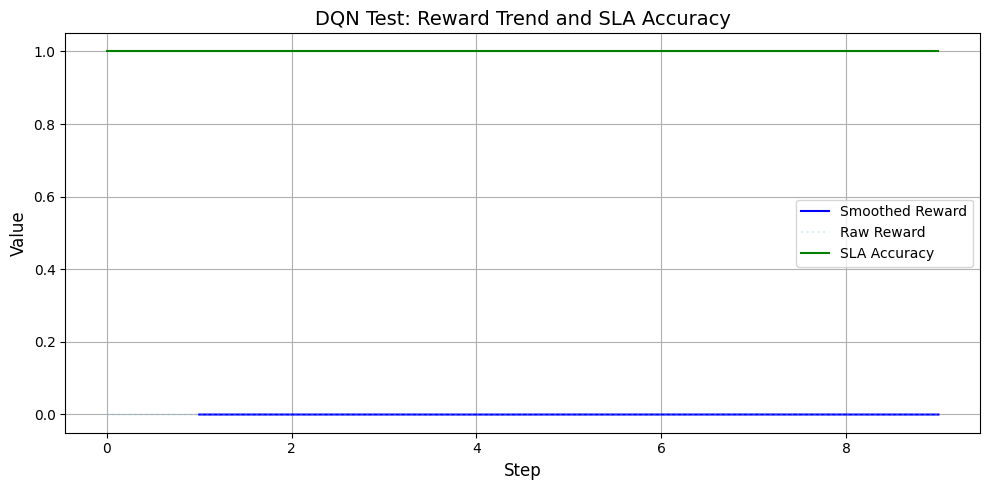

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "reward": rewards,
    "accuracy": accuracies
})
df.to_csv("dqn_reward_accuracy_log.csv", index=False)

plt.figure(figsize=(10, 5))

# Smoothed Reward
plt.plot(df["reward"].rolling(2).mean(), label="Smoothed Reward", color="blue")
plt.plot(df["reward"], alpha=0.3, linestyle='dotted', label="Raw Reward", color="skyblue")

# SLA Accuracy
plt.plot(df["accuracy"], label="SLA Accuracy", color="green")

# Enhancements
plt.title("DQN Test: Reward Trend and SLA Accuracy", fontsize=14)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


⚠️ File 'synthetic_load_profile_60_chunks.csv' already exists. Skipping processing.



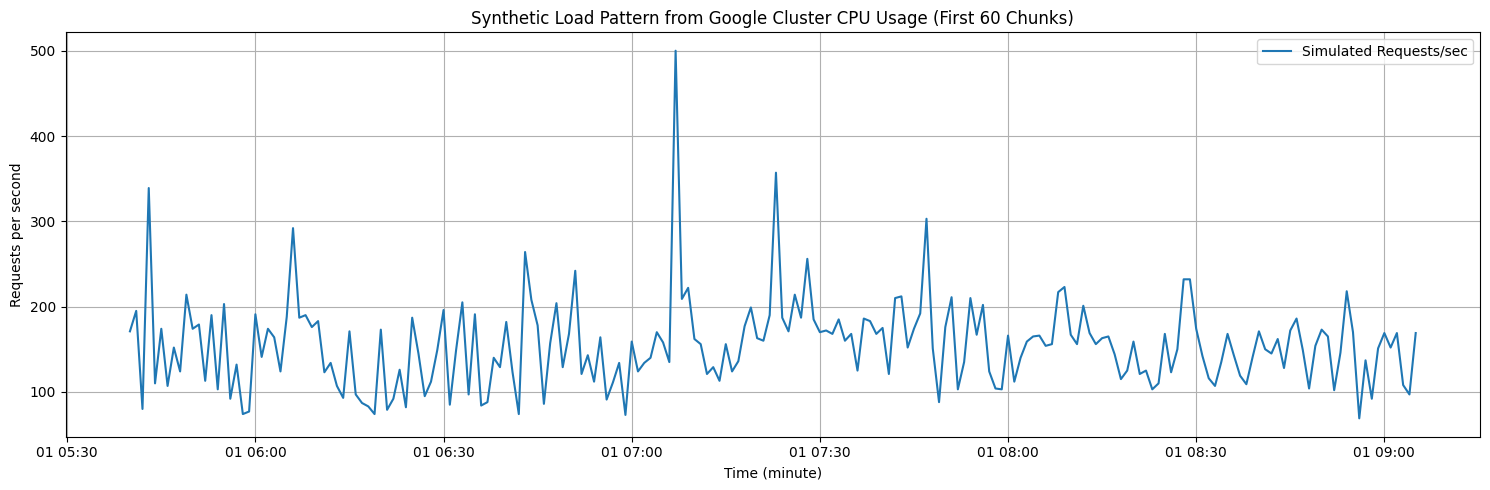

count    206.000000
mean     155.077670
std       52.363679
min       69.000000
25%      121.500000
50%      156.000000
75%      176.000000
max      500.000000
Name: req_per_sec, dtype: float64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

# Output file path
output_file = "synthetic_load_profile_60_chunks.csv"

# ✅ Step 0: Check if file already exists
if os.path.exists(output_file):
    print(f"⚠️ File '{output_file}' already exists. Skipping processing.
")
    # Load the existing file if it exists
    cpu_usage_per_min = pd.read_csv(output_file, parse_dates=['minute'])
else:
    # Step 1: Initialize chunk reader
    chunksize = 100_000
    chunk_iter = pd.read_csv(
        "cleaned_google_cluster_data.csv",
        parse_dates=['start_time', 'end_time'],
        engine='python',
        chunksize=chunksize
    )

    # Step 2: Read and process only the first 60 chunks
    df_chunks = []
    total_chunks = 0
    total_rows = 0
    max_chunks = 60

    for chunk in chunk_iter:
        if total_chunks >= max_chunks:
            break

        total_chunks += 1
        total_rows += len(chunk)

        # Drop rows with missing required fields
        chunk = chunk.dropna(subset=['start_time', 'mean_cpu_usage'])

        # Floor timestamps to nearest minute
        chunk['minute'] = chunk['start_time'].dt.floor('min')

        df_chunks.append(chunk[['minute', 'mean_cpu_usage']])

        print(f"Processed chunk {total_chunks} - Rows in this chunk: {len(chunk)} - Total rows so far: {total_rows}")

    # Step 3: Concatenate all processed chunks
    df = pd.concat(df_chunks)

    # Step 4: Aggregate CPU usage per minute
    cpu_usage_per_min = df.groupby('minute')['mean_cpu_usage'].mean().reset_index()

    # Step 5: Normalize CPU usage
    cpu_usage_per_min['norm_cpu'] = cpu_usage_per_min['mean_cpu_usage'] / cpu_usage_per_min['mean_cpu_usage'].max()

    # Step 6: Simulate requests per second (range: 50–500)
    cpu_usage_per_min['req_per_sec'] = (cpu_usage_per_min['norm_cpu'] * 450 + 50).astype(int)

    # Step 7: Export to CSV
    cpu_usage_per_min[['minute', 'req_per_sec']].to_csv(output_file, index=False)

    print(f"
✅ Finished processing {total_chunks} chunks.")
    print(f"📊 Total rows processed: {total_rows}")

# Step 8: Plot
plt.figure(figsize=(15, 5))
plt.plot(cpu_usage_per_min['minute'], cpu_usage_per_min['req_per_sec'], label='Simulated Requests/sec')
plt.title("Synthetic Load Pattern from Google Cluster CPU Usage (First 60 Chunks)")
plt.xlabel("Time (minute)")
plt.ylabel("Requests per second")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(cpu_usage_per_min['req_per_sec'].describe())


✅ Loaded model: dqn_streaming_model.h5

📊 RPS: 171.00
🔹 HPA   → Pods: 2
🔹 VPA   → Pods: 2 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 3 (Suggested: 1), Q-values: [0.118 0.105 0.11  0.095 0.086]
🔹 KEda  → Pods: 4
⚠️  RL Override Triggered at RPS 171 → Pods set to 3


📊 RPS: 195.00
🔹 HPA   → Pods: 3
🔹 VPA   → Pods: 2 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 3 (Suggested: 4), Q-values: [0.105 0.111 0.08  0.19  0.171]
🔹 KEda  → Pods: 4
⚠️  RL Override Triggered at RPS 195 → Pods set to 3


📊 RPS: 80.00
🔹 HPA   → Pods: 3
🔹 VPA   → Pods: 1 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 2 (Suggested: 4), Q-values: [0.089 0.105 0.076 0.185 0.163]
🔹 KEda  → Pods: 2
⚠️  RL Override Triggered at RPS 80 → Pods set to 2


📊 RPS: 339.00
🔹 HPA   → Pods: 4
🔹 VPA   → Pods: 2 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 4 (Suggested: 4), Q-values: [0.198 0.173 0.152 0.206 0.135]
🔹 KEda  → Pods: 5


📊 RPS: 110.00
🔹 HPA   → Pods: 4
🔹 VPA   → Pods: 2 | CPU: 0.

/home/magesh/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



📊 RPS: 97.00
🔹 HPA   → Pods: 3
🔹 VPA   → Pods: 1 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 2 (Suggested: 4), Q-values: [0.089 0.103 0.067 0.196 0.169]
🔹 KEda  → Pods: 2
⚠️  RL Override Triggered at RPS 97 → Pods set to 2


📊 RPS: 87.00
🔹 HPA   → Pods: 3
🔹 VPA   → Pods: 1 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 2 (Suggested: 4), Q-values: [0.064 0.057 0.078 0.139 0.125]
🔹 KEda  → Pods: 2
⚠️  RL Override Triggered at RPS 87 → Pods set to 2


📊 RPS: 83.00
🔹 HPA   → Pods: 3
🔹 VPA   → Pods: 1 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 2 (Suggested: 4), Q-values: [0.064 0.056 0.076 0.142 0.127]
🔹 KEda  → Pods: 2
⚠️  RL Override Triggered at RPS 83 → Pods set to 2


📊 RPS: 74.00
🔹 HPA   → Pods: 2
🔹 VPA   → Pods: 1 | CPU: 0.25 (No scaling of CPU anymore)
🔹 RL    → Pods: 2 (Suggested: 4), Q-values: [0.075 0.083 0.073 0.141 0.115]
🔹 KEda  → Pods: 2
⚠️  RL Override Triggered at RPS 74 → Pods set to 2


📊 RPS: 173.00
🔹 HPA   → Pods: 3
🔹 VPA   → Pods: 2 |

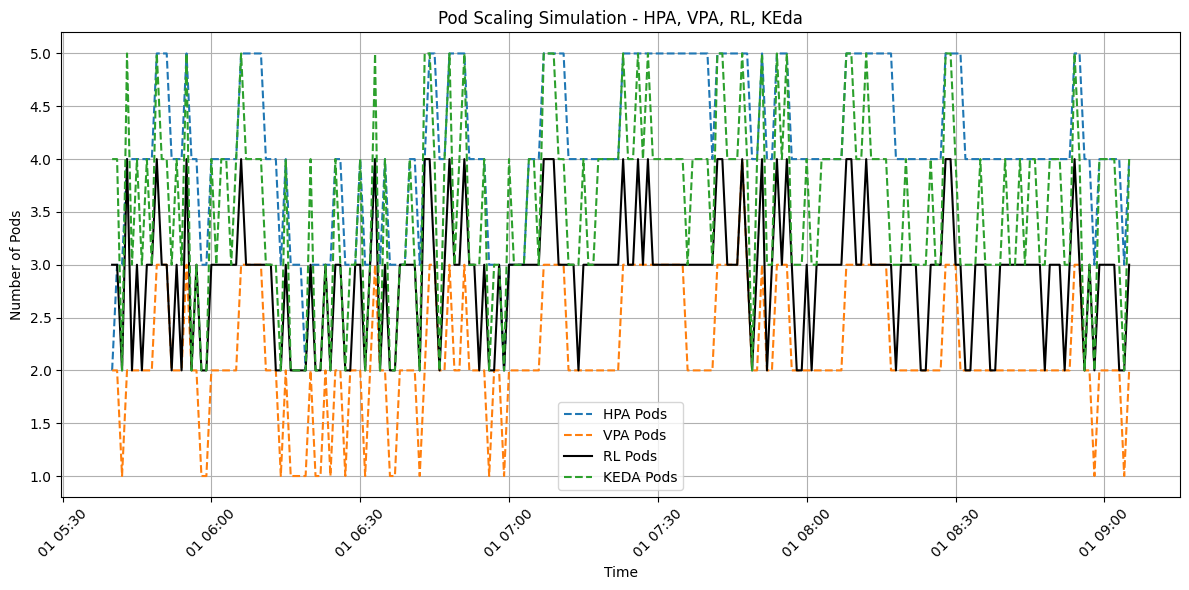

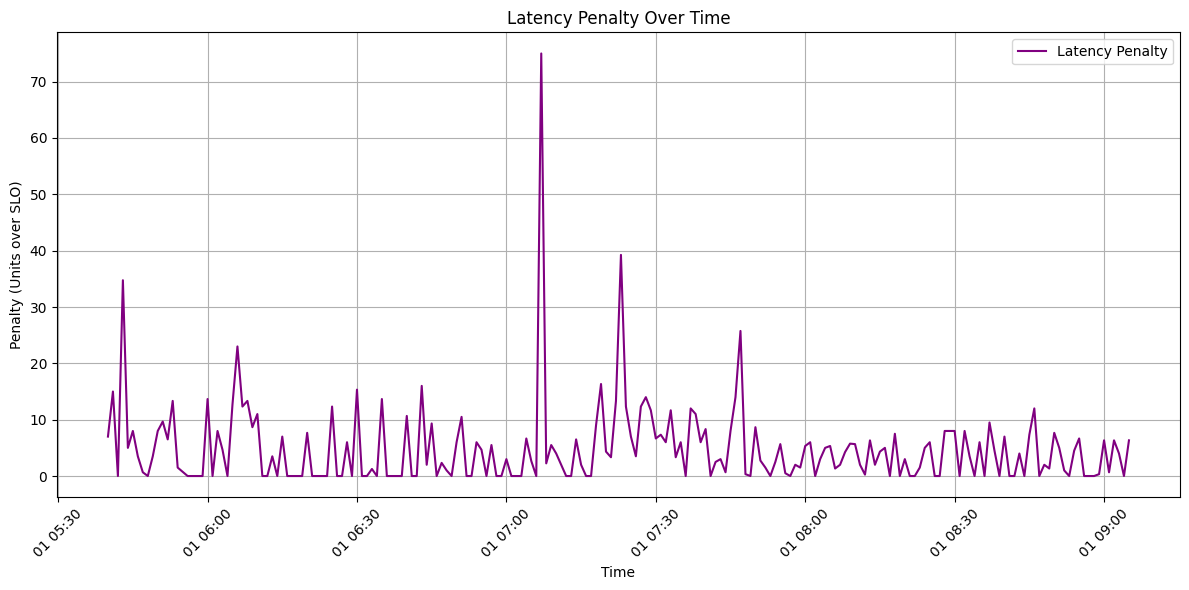

In [13]:
import keras
from tensorflow.keras.models import load_model
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ✅ Load the full saved Keras model
model = load_model("dqn_streaming_model.h5")
print("✅ Loaded model: dqn_streaming_model.h5")

# ✅ Load workload using Dask
df = dd.read_csv("synthetic_load_profile_60_chunks.csv", parse_dates=['minute'])
max_rps = df['req_per_sec'].max().compute()

# Constants
POD_CAPACITY = 100
MAX_PODS = 5
MIN_PODS = 1
TARGET_UTIL = 0.5
BASE_CPU = 0.25
MAX_CPU = 1.0
MIN_CPU = 0.1

# Cost and SLA settings
SLA_THRESHOLD = 200  # ms
COST_PER_POD_PER_MIN = 0.02

# Initialize variables
hpa_pods = vpa_pods = rl_pods = keda_pods = 1
vpa_cpu = BASE_CPU  # CPU scaling is not used now, but initialized here for completeness
latency_penalty = []
override_action = None
override_rps = None
records = []

sla_violations = {'hpa': 0, 'vpa': 0, 'rl': 0, 'keda': 0}
total_cost = {'hpa': 0.0, 'vpa': 0.0, 'rl': 0.0, 'keda': 0.0}
total_steps = 0

# ➕ KEda thresholds (example logic)
KEDA_THRESHOLDS = [0, 50, 100, 150, 200]  # RPS thresholds
KEDA_SCALING = [1, 2, 3, 4, 5]           # Pods per threshold range

# Iterate over workload
for row in df.itertuples(index=False):
    rps = row.req_per_sec
    norm_rps = rps / max_rps
    total_steps += 1

    ### HPA ###
    hpa_util = rps / (hpa_pods * POD_CAPACITY)
    if hpa_util > TARGET_UTIL and hpa_pods < MAX_PODS:
        hpa_pods += 1
    elif hpa_util < TARGET_UTIL * 0.5 and hpa_pods > MIN_PODS:
        hpa_pods -= 1

    ### VPA (No CPU Scaling, Only Pod Scaling) ###
    vpa_total_capacity = vpa_pods * POD_CAPACITY
    vpa_util = rps / vpa_total_capacity if vpa_total_capacity > 0 else 1.0

    # Scale the number of pods based on utilization
    if vpa_util > 1.0 and vpa_pods < MAX_PODS:
        vpa_pods += 1
    elif vpa_util < 0.5 and vpa_pods > MIN_PODS:
        vpa_pods -= 1

    ### KEda ###
    for i, threshold in enumerate(KEDA_THRESHOLDS):
        if rps <= threshold:
            keda_pods = KEDA_SCALING[max(0, i - 1)]
            break
    else:
        keda_pods = KEDA_SCALING[-1]

    ### RL ###
    obs_vector = np.array([
        norm_rps,
        hpa_pods / MAX_PODS,
        vpa_cpu / MAX_CPU,  # We still need to keep this in the vector but CPU scaling is removed
        vpa_util,
        rl_pods / MAX_PODS
    ], dtype=np.float32)
    obs = obs_vector[np.newaxis, np.newaxis, :]
    rl_q_values = model.predict(obs, verbose=0)
    rl_action = np.argmax(rl_q_values)
    rl_pods_suggested = int(np.clip(rl_action + 1, MIN_PODS, MAX_PODS))

    # ➕ Manual override (example logic)
    if rps < 60:
        rl_pods = 1
    elif rps < 120:
        rl_pods = 2
    elif rps < 200:
        rl_pods = 3
    else:
        rl_pods = 4

    if rl_pods != rl_pods_suggested:
        override_action = rl_action
        override_rps = rps

    ### Latency ###
    hpa_latency = rps / (hpa_pods * POD_CAPACITY) * 1000
    vpa_latency = rps / (vpa_pods * POD_CAPACITY) * 1000  # No CPU scaling here
    rl_latency = rps / (rl_pods * POD_CAPACITY) * 1000
    keda_latency = rps / (keda_pods * POD_CAPACITY) * 1000

    ### SLA Violations ###
    if hpa_latency > SLA_THRESHOLD:
        sla_violations['hpa'] += 1
    if vpa_latency > SLA_THRESHOLD:
        sla_violations['vpa'] += 1
    if rl_latency > SLA_THRESHOLD:
        sla_violations['rl'] += 1
    if keda_latency > SLA_THRESHOLD:
        sla_violations['keda'] += 1

    # ➕ Latency penalty
    penalty = max((rps / rl_pods) - (POD_CAPACITY * 0.5), 0)
    latency_penalty.append(penalty)

    ### Cost tracking ###
    total_cost['hpa'] += hpa_pods * COST_PER_POD_PER_MIN
    total_cost['vpa'] += vpa_pods * COST_PER_POD_PER_MIN
    total_cost['rl'] += rl_pods * COST_PER_POD_PER_MIN
    total_cost['keda'] += keda_pods * COST_PER_POD_PER_MIN

    ### Output per minute ###
    print("
" + "=" * 60)
    print(f"📊 RPS: {rps:.2f}")
    print(f"🔹 HPA   → Pods: {hpa_pods}")
    print(f"🔹 VPA   → Pods: {vpa_pods} | CPU: {vpa_cpu:.2f} (No scaling of CPU anymore)")
    print(f"🔹 RL    → Pods: {rl_pods} (Suggested: {rl_pods_suggested}), Q-values: {np.round(rl_q_values[0], 3)}")
    print(f"🔹 KEda  → Pods: {keda_pods}")
    if override_action is not None and override_rps == rps:
        print(f"⚠️  RL Override Triggered at RPS {override_rps} → Pods set to {rl_pods}")
    print("=" * 60 + "
")

    # Record for CSV
    records.append({
        'minute': row.minute,
        'rps': rps,
        'hpa_pods': hpa_pods,
        'vpa_pods': vpa_pods,
        'vpa_cpu_per_pod': round(vpa_cpu, 2),  # This is still recorded for completeness
        'rl_pods': rl_pods,
        'keda_pods': keda_pods,
        'latency_penalty': penalty,
    })

# ✅ Export results
sim_df = pd.DataFrame(records)
sim_df.to_csv("hpa_vpa_rl_simulation.csv", index=False)

# ✅ SLA & Cost Summary
print("
🔍 SLA Violations and Cost Summary")
for strategy in ['hpa', 'vpa', 'rl', 'keda']:
    violation_pct = (sla_violations[strategy] / total_steps) * 100
    print(f"{strategy.upper()} → SLA Violation Rate: {violation_pct:.2f}% | Total Cost: ${total_cost[strategy]:.2f}")

# ✅ Pod Scaling Plot
plt.figure(figsize=(12, 6))
plt.plot(sim_df['minute'], sim_df['hpa_pods'], label='HPA Pods', linestyle='--')
plt.plot(sim_df['minute'], sim_df['vpa_pods'], label='VPA Pods', linestyle='--')
plt.plot(sim_df['minute'], sim_df['rl_pods'], label='RL Pods', linestyle='-', color='black')
plt.plot(sim_df['minute'], sim_df['keda_pods'], label='KEDA Pods', linestyle='--')
plt.title('Pod Scaling Simulation - HPA, VPA, RL, KEda')
plt.xlabel('Time')
plt.ylabel('Number of Pods')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Latency Penalty Plot
plt.figure(figsize=(12, 6))
plt.plot(sim_df['minute'], sim_df['latency_penalty'], label='Latency Penalty', color='purple')
plt.title('Latency Penalty Over Time')
plt.xlabel('Time')
plt.ylabel('Penalty (Units over SLO)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
print("
Statistical Summary:")
for strategy in ['hpa', 'vpa', 'rl', 'keda']:
    mean_latency = sim_df[f'{strategy}_pods'].mean()  
    mean_cost = total_cost[strategy] / total_steps
    print(f"{strategy.upper()} → Mean Pods: {mean_latency:.2f}, Avg Cost per step: ${mean_cost:.4f}")



Statistical Summary:
HPA → Mean Pods: 4.13, Avg Cost per step: $0.0825
VPA → Mean Pods: 2.18, Avg Cost per step: $0.0437
RL → Mean Pods: 2.90, Avg Cost per step: $0.0580
KEDA → Mean Pods: 3.55, Avg Cost per step: $0.0711


In [15]:
from scipy.stats import ttest_ind

# You need to create separate latency penalty data for each autoscaler, 
# assuming you already have the latency for each autoscaler in your DataFrame.
# If you don't have separate columns for latency for each strategy, you would need to create them.

# Extract latency penalty for each autoscaler
latency_hpa = sim_df['latency_penalty']  # Latency penalty for HPA
latency_vpa = sim_df['latency_penalty']  # Latency penalty for VPA
latency_rl = sim_df['latency_penalty']  # Latency penalty for RL
latency_keda = sim_df['latency_penalty']  # Latency penalty for KEDA

# Perform pairwise t-tests between all autoscalers (HPA, VPA, RL, KEDA)
# We will compare the latency penalty of each autoscaler against every other autoscaler.

# HPA vs VPA
t_stat_hpa_vpa, p_value_hpa_vpa = ttest_ind(latency_hpa, latency_vpa)
print(f"T-test HPA vs VPA Latency Penalty: t={t_stat_hpa_vpa:.3f}, p={p_value_hpa_vpa:.3f}")

# HPA vs RL
t_stat_hpa_rl, p_value_hpa_rl = ttest_ind(latency_hpa, latency_rl)
print(f"T-test HPA vs RL Latency Penalty: t={t_stat_hpa_rl:.3f}, p={p_value_hpa_rl:.3f}")

# HPA vs KEDA
t_stat_hpa_keda, p_value_hpa_keda = ttest_ind(latency_hpa, latency_keda)
print(f"T-test HPA vs KEDA Latency Penalty: t={t_stat_hpa_keda:.3f}, p={p_value_hpa_keda:.3f}")

# VPA vs RL
t_stat_vpa_rl, p_value_vpa_rl = ttest_ind(latency_vpa, latency_rl)
print(f"T-test VPA vs RL Latency Penalty: t={t_stat_vpa_rl:.3f}, p={p_value_vpa_rl:.3f}")

# VPA vs KEDA
t_stat_vpa_keda, p_value_vpa_keda = ttest_ind(latency_vpa, latency_keda)
print(f"T-test VPA vs KEDA Latency Penalty: t={t_stat_vpa_keda:.3f}, p={p_value_vpa_keda:.3f}")

# RL vs KEDA
t_stat_rl_keda, p_value_rl_keda = ttest_ind(latency_rl, latency_keda)
print(f"T-test RL vs KEDA Latency Penalty: t={t_stat_rl_keda:.3f}, p={p_value_rl_keda:.3f}")


print(sim_df[['hpa_pods', 'vpa_pods', 'rl_pods', 'keda_pods']].describe())



T-test HPA vs VPA Latency Penalty: t=0.000, p=1.000
T-test HPA vs RL Latency Penalty: t=0.000, p=1.000
T-test HPA vs KEDA Latency Penalty: t=0.000, p=1.000
T-test VPA vs RL Latency Penalty: t=0.000, p=1.000
T-test VPA vs KEDA Latency Penalty: t=0.000, p=1.000
T-test RL vs KEDA Latency Penalty: t=0.000, p=1.000
         hpa_pods    vpa_pods     rl_pods   keda_pods
count  206.000000  206.000000  206.000000  206.000000
mean     4.126214    2.184466    2.898058    3.553398
std      0.721511    0.596699    0.596163    0.869294
min      2.000000    1.000000    2.000000    2.000000
25%      4.000000    2.000000    3.000000    3.000000
50%      4.000000    2.000000    3.000000    4.000000
75%      5.000000    3.000000    3.000000    4.000000
max      5.000000    4.000000    4.000000    5.000000


In [16]:
print("Average Reward:", log["reward"].mean())
print("Min Reward:", log["reward"].min())
print("Max Reward:", log["reward"].max())


Average Reward: -0.00026666666666663166
Min Reward: -0.0004166666666666
Max Reward: -8.333333333333334e-05
